In [1]:
# Configuration and My libs
%config IPCompleter.greedy = True
%config IPCompleter.merge_completions = True
%config IPCompleter.limit_to__all__ = False
%matplotlib inline

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import pickle
import cv2 as cv
import skimage
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.externals import joblib
from skimage.transform import rotate

import theano
import theano.tensor as T
import keras.backend as K

import keras
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Activation, Dropout, Flatten, Merge
from keras.layers.convolutional import Convolution2D, AtrousConvolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU,LeakyReLU
from keras.optimizers import Adam, Adamax
from keras.callbacks import LearningRateScheduler, LambdaCallback, ModelCheckpoint
from keras.regularizers import l2
from keras.utils.visualize_util import plot as keras_plot



Using Theano backend.


In [2]:
#Load the data
FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

       
def make_submission(test_labels,submission_name):
    test_labels *= 48.0
    test_labels += 48.0
    test_labels = test_labels.clip(0, 96)

    lookup_table = pd.read_csv(FLOOKUP)
    values = []

    cols = joblib.load('cols.pkl')

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            test_labels[row.ImageId - 1][np.where(cols == row.FeatureName)[0][0]],
            ))
    submission = pd.DataFrame(values, columns=('RowId', 'Location'))
    submission.to_csv(submission_name, index=False)
    
def load(test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    
    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def augment_rotate(X, y):
    rotated_X = np.zeros_like(X)
    rotated_y = np.zeros_like(y)
    for i in range(X.shape[0]):
        img = X[i].reshape((96,96))/255.0
        labels = y[i]
        angle = np.random.randint(low=-10, high=10) * (np.pi/180.0)
        for j in np.arange(0, labels.shape[0], 2):
            R = np.sqrt(labels[j]**2 + labels[j+1]**2)
            theta = np.arctan2(labels[j+1], labels[j])
            rotated_y[i][j] = R * np.cos(theta - angle)
            rotated_y[i][j+1] = R * np.sin(theta - angle)
        rotated_X[i] = rotate(img, angle*(180/np.pi)).reshape((96*96,)) * 255
    return rotated_X, rotated_y

def augment_flip (x,y):
    x=x.reshape(-1,96,96)
    y=y.reshape(x.shape[0],-1)
    xx=x.copy()
    yy=y.copy()
    for i in range (x.shape[0]):
        xx[i]=np.fliplr(x[i])
    ran=range(0,y.shape[1],2)
    yy[:,ran]*=-1
    return xx.reshape(-1,9216),yy


def augment_blur (x,y):
    x=x.reshape(-1,96,96)
    y=y.reshape(x.shape[0],-1)
    xx=x.copy()
    yy=y.copy()
    for i in range (x.shape[0]):
        kernel = np.ones((7,7),np.float32)/49
        xx[i] = cv.filter2D(x[i],-1,kernel)
    return xx.reshape(-1,9216),yy

def augment_noise (x,y):
    xx=x.copy()
    yy=y.copy()
    xx=xx.reshape(-1,96,96)
    yy=yy.reshape(x.shape[0],-1)
    
    for i in range (x.shape[0]):
        xx[i] = skimage.util.random_noise(xx[i], mode='gaussian', clip=True)
        xx[i] = skimage.util.random_noise(xx[i], mode='s&p', clip=True, amount=0.01)
    
    return xx.reshape(-1,9216),yy
    

In [3]:
#####################################################
cols_l = ('left_eye_inner_corner_x', 
          'left_eye_inner_corner_y', 
          'left_eye_outer_corner_x', 
          'left_eye_outer_corner_y', 
          'left_eyebrow_inner_end_x', 
          'left_eyebrow_inner_end_y', 
          'left_eyebrow_outer_end_x', 
          'left_eyebrow_outer_end_y', 
          'mouth_left_corner_x', 
          'mouth_left_corner_y', 
          'mouth_center_top_lip_x', 
          'mouth_center_top_lip_y')
#####################################################
cols_r = ('right_eye_inner_corner_x', 
          'right_eye_inner_corner_y', 
          'right_eye_outer_corner_x', 
          'right_eye_outer_corner_y', 
          'right_eyebrow_inner_end_x', 
          'right_eyebrow_inner_end_y', 
          'right_eyebrow_outer_end_x', 
          'right_eyebrow_outer_end_y', 
          'mouth_right_corner_x', 
          'mouth_right_corner_y',
          'mouth_center_top_lip_x', 
          'mouth_center_top_lip_y')

# Load the left and the right data
X_r, y_r = load(cols=cols_r)
X_l, y_l = load(cols=cols_l)

# blur the data
X_b, y_b = augment_blur(X_r, y_r)

# flip the left data
X_f, y_f = augment_flip(X_l, y_l)

# noise the original data
X_n, y_n = augment_noise(X_r, y_r)

# Original + flip + blur + noise
X_o_f = np.concatenate((X_r, X_f, X_b, X_n))
y_o_f = np.concatenate((y_r, y_f, y_b, y_n))

# rotate all the previous
X_ro, y_ro = augment_rotate(X_o_f, y_o_f)

# Concatenate the original and the rotated
X = np.concatenate((X_o_f, X_ro))
y = np.concatenate((y_o_f, y_ro))

X, y = shuffle(X, y, random_state=42)  # shuffle train data

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
Image                        7049
dtype: int64
left_eye_inner_corner_x     2271
left_eye_inner_corner_y     2271
left_eye_outer_corner_x     2267
left_eye_outer_corner_y     2267
left_eyebrow_inner_end_x    2270
left_eyebrow_inner_end_y    2270
left_eyebrow_outer_end_x    2225
left_eyebrow_outer_end_y    2225
mouth_left_corner_x         2269
mouth_left_corner_y         2269
mouth_center_top_lip_x      2275
mouth_center_top_lip_y      2275
Image                       7049
dtype: int64
X.shape == (17640, 9216); X.min == 0.000; X.max == 1.000
y.shape == (17640, 12); y.min == -0.994; y.max

In [ ]:
###Don't run this

X_r, y_r = load(cols=cols_r)

X_, _ = augment_noise(X_r,y_r)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_sample(X_[i+30], y[i+30], ax)

plt.show()

In [ ]:
#Test train data visualization
X_=X.reshape((-1,1,96,96))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_sample(X_[i+30], y[i+30], ax)

plt.show()

In [4]:
def build_model():
    ########################################################################################
    input_img = Input(shape=(1, 96, 96))

    conv_1 = Convolution2D(32, 3, 3, border_mode='same', subsample=(1, 1), init='he_normal', W_regularizer = l2(1e-4))(input_img)
    conv_1 = BatchNormalization(mode=2, axis=1)(conv_1)
    conv_1 = LeakyReLU(alpha=0.05)(conv_1)
    conv_1 = Dropout(0.3)(conv_1)
    
    conv_2 = Convolution2D(16, 3, 3, border_mode='same', subsample=(1, 1), init='he_normal', W_regularizer = l2(1e-4))(conv_1)
    conv_2 = BatchNormalization(mode=2, axis=1)(conv_2)
    conv_2 = LeakyReLU(alpha=0.05)(conv_2)
    conv_2 = Dropout(0.3)(conv_2)
    
    conv_3 = Convolution2D(8, 1, 1, border_mode='same', subsample=(1, 1), init='he_normal', W_regularizer = l2(1e-4))(conv_2)
    conv_3 = BatchNormalization(mode=2, axis=1)(conv_3)
    conv_3 = LeakyReLU(alpha=0.05)(conv_3)
    conv_3 = Dropout(0.3)(conv_3)

    fc_1 = Flatten()(conv_3) # Prepare for the fully connected Network

    fc_1 = Dense(64,init='he_normal', W_regularizer = l2(1e-4))(fc_1)
    fc_1 = BatchNormalization(mode=2, axis=1)(fc_1)
    fc_1 = LeakyReLU(alpha=0.05)(fc_1)
    fc_1 = Dropout(0.2)(fc_1)

    fc_2 = Dense(32,init='he_normal', W_regularizer = l2(1e-4))(fc_1)
    fc_2 = BatchNormalization(mode=2, axis=1)(fc_2)
    fc_2 = LeakyReLU(alpha=0.05)(fc_2)
    fc_2 = Dropout(0.2)(fc_2)
    
    fc_3 = Dense(16,init='he_normal', W_regularizer = l2(1e-4))(fc_2)
    fc_3 = BatchNormalization(mode=2, axis=1)(fc_3)
    fc_3 = LeakyReLU(alpha=0.05)(fc_3)
    fc_3 = Dropout(0.2)(fc_3)

    out = Dense(12,activation='linear',init='glorot_uniform')(fc_3)

    ########################################################################################

    model = Model(input=input_img, output=out, name='Facial_points_model')
    my_adamax = Adamax(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=my_adamax, loss='mse', metrics=['accuracy'])
    keras_plot(model, to_file='model.png')
    return model

model = build_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 96, 96)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 96, 96)    320         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 96, 96)    64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 32, 96, 96)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [5]:
print "oo"
X_train=X.reshape((-1,1,96,96)) #Prepare our data by reshaping it
Y_train=y
#Clip some for overfitting
# X_train = X_train[:100]
# Y_train = y[:100]

print X_train.shape,Y_train.shape

oo
(17640, 1, 96, 96) (17640, 12)


In [16]:
# Our callbacks
########################################################################
class learning_rate_tracker(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print "\nLearning rate = %f " % model.optimizer.lr.get_value()
        
def scheduler(epoch):
    if epoch == 5:
        model.optimizer.lr.set_value(.0005)
    elif epoch == 10:
        model.optimizer.lr.set_value(.01)
    elif epoch == 15:
        model.optimizer.lr.set_value(.005)
    elif epoch == 20:
        model.optimizer.lr.set_value(.001)
    return float(model.optimizer.lr.get_value())

lr_changer = LearningRateScheduler(scheduler)
lr_tracker = learning_rate_tracker()
model_checkpointer = ModelCheckpoint('chks/facial{epoch:02d}.hdf5.h5', save_best_only=True)

callbacks_list = [lr_changer ,lr_tracker ,model_checkpointer]

model.optimizer.lr.set_value(.00005)

# The main loop
#########################################################################
try:
    start = time.time()
    history__ = model.fit(X_train, Y_train, batch_size=128, nb_epoch=2, verbose=1, validation_split=0.025,callbacks=callbacks_list,shuffle=True)
    end = time.time()
except KeyboardInterrupt:
    print "\nStopped Manually"
    pass
#########################################################################

print '\nElapsed Time : %d seconds' % (end-start)

Train on 17199 samples, validate on 441 samples

Learning rate = 0.000050 
Epoch 1/2
17199/17199 [==============================] - 2741s - loss: 0.0449 - acc: 0.8338 - val_loss: 0.0022 - val_acc: 0.8005

Learning rate = 0.000050 
Epoch 2/2
17199/17199 [==============================] - 2734s - loss: 0.0446 - acc: 0.8339 - val_loss: 0.0022 - val_acc: 0.7982

Elapsed Time : 5475 seconds


['acc', 'loss', 'val_acc', 'val_loss']


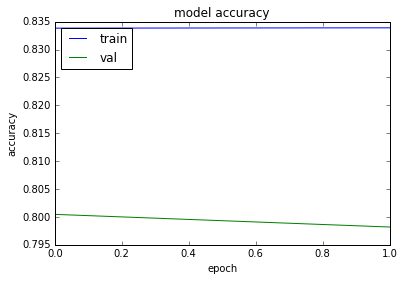

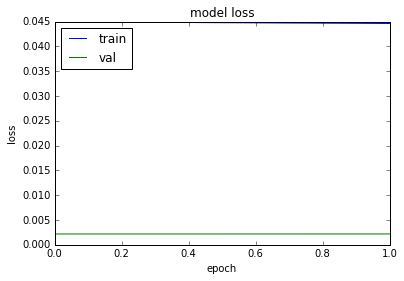

In [17]:
history = history__
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ImageId    1783
Image      1783
dtype: int64


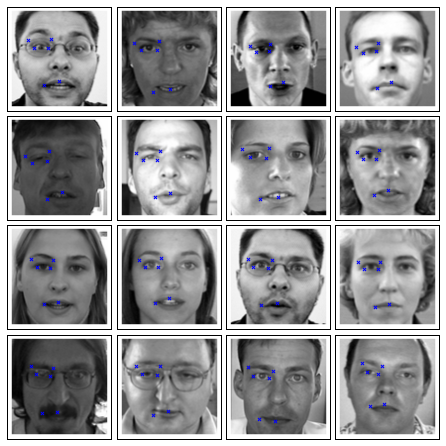

In [18]:
X, _ = load(test=True,cols=None)
X    = (X.reshape((-1,1,96,96)))[:16]
y_pred = model.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()

In [ ]:
tst = load(test=True)[0].reshape(-1, 1, 96, 96)
y_pred1 = model.predict(tst)
print y_pred1.shape, tst.shape
make_submission(y_pred1,'submission_1.csv')

In [19]:
tst = load(test=True)[0].reshape(-1, 1, 96, 96)
y_pred1 = model.predict(tst)
np.save('my_turn.npz',y_pred1)

ImageId    1783
Image      1783
dtype: int64


In [20]:
###################################################Save the Model and the weights
# serialize model to JSON
model_json = model.to_json()
with open("model_keras_lst.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_keras_lst.h5", overwrite=True)
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_keras_lst.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_keras_lst.h5")
my_adamax = Adamax(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=my_adamax, loss='mean_squared_error', metrics=['accuracy'])
keras_plot(model, to_file='model.png')
print("Loaded model from disk")